# GRU Model Training for Runner Injury Prediction (Daily Approach)

This notebook implements a GRU model for predicting runner injuries using the daily approach data. Key features:

1. Data loading and preparation
2. Class imbalance handling
3. GRU model architecture
4. Training with GPU acceleration
5. Comprehensive evaluation metrics
6. Performance visualization


In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import pandas as pd
from tqdm.notebook import tqdm
import pickle

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [12]:
# Load preprocessed data
X_train = np.load('preprocessed_data/X_daily_train.npy')
X_val = np.load('preprocessed_data/X_daily_val.npy')
y_train = np.load('preprocessed_data/y_daily_train.npy')
y_val = np.load('preprocessed_data/y_daily_val.npy')

# Load feature names
with open('preprocessed_data/daily_features.pkl', 'rb') as f:
    feature_names = pickle.load(f)

# Calculate class weights for handling imbalance
pos_weight = torch.tensor((1 - y_train.mean()) / y_train.mean()).to(device)

print("Data shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_val: {y_val.shape}")
print(f"\nClass distribution in training set:")
print(f"Injury rate: {y_train.mean():.2%}")
print(f"No injury rate: {1 - y_train.mean():.2%}")
print(f"\nClass distribution in validation set:")
print(f"Injury rate: {y_val.mean():.2%}")
print(f"No injury rate: {1 - y_val.mean():.2%}")
print(f"\nCalculated positive class weight: {pos_weight.item():.2f}")

# Add Focal Loss as an option
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * bce_loss
        return focal_loss.mean()

# Choose which loss function to use
USE_FOCAL_LOSS = False  # Set to True to use Focal Loss instead of BCE
criterion = FocalLoss(alpha=0.25, gamma=2.0) if USE_FOCAL_LOSS else nn.BCEWithLogitsLoss(pos_weight=pos_weight)


Data shapes:
X_train: (34207, 7, 70)
X_val: (8552, 7, 70)
y_train: (34207,)
y_val: (8552,)

Class distribution in training set:
Injury rate: 1.36%
No injury rate: 98.64%

Class distribution in validation set:
Injury rate: 1.37%
No injury rate: 98.63%

Calculated positive class weight: 72.41


In [13]:
# Model Hyperparameters
SEQUENCE_LENGTH = 7  # 7 days window
N_FEATURES = X_train.shape[2]
HIDDEN_SIZE = 64
NUM_LAYERS = 2
DROPOUT = 0.3
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
NUM_EPOCHS = 100
EARLY_STOPPING_PATIENCE = 10

# Thresholds for prediction
CLASSIFICATION_THRESHOLD = 0.5  # Can be tuned later based on precision-recall trade-off

print("Model Configuration:")
print(f"Sequence Length: {SEQUENCE_LENGTH}")
print(f"Number of Features: {N_FEATURES}")
print(f"Hidden Size: {HIDDEN_SIZE}")
print(f"Number of GRU Layers: {NUM_LAYERS}")
print(f"Dropout Rate: {DROPOUT}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Number of Epochs: {NUM_EPOCHS}")
print(f"Early Stopping Patience: {EARLY_STOPPING_PATIENCE}")
print(f"Classification Threshold: {CLASSIFICATION_THRESHOLD}")


Model Configuration:
Sequence Length: 7
Number of Features: 70
Hidden Size: 64
Number of GRU Layers: 2
Dropout Rate: 0.3
Learning Rate: 0.0001
Batch Size: 32
Number of Epochs: 100
Early Stopping Patience: 10
Classification Threshold: 0.5


In [14]:
# Custom Dataset class
class RunnerInjuryDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create data loaders
train_dataset = RunnerInjuryDataset(X_train, y_train)
val_dataset = RunnerInjuryDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# GRU Model
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1)
        )
    
    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)
        gru_out, _ = self.gru(x)
        # Use only the last output
        out = self.fc(gru_out[:, -1, :])
        return out.squeeze()

# Initialize model
model = GRUModel(
    input_size=N_FEATURES,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Model architecture:")
print(model)


Model architecture:
GRUModel(
  (gru): GRU(70, 64, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=32, out_features=1, bias=True)
    (4): Sigmoid()
  )
)


In [17]:
# Training and evaluation functions
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    predictions = []
    targets = []
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        predictions.extend(torch.sigmoid(outputs).detach().cpu().numpy())
        targets.extend(y_batch.cpu().numpy())
    
    return total_loss / len(train_loader), predictions, targets

def evaluate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    predictions = []
    targets = []
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            total_loss += loss.item()
            predictions.extend(torch.sigmoid(outputs).detach().cpu().numpy())
            targets.extend(y_batch.cpu().numpy())
    
    return total_loss / len(val_loader), predictions, targets

def calculate_metrics(y_true, y_pred, threshold=CLASSIFICATION_THRESHOLD):
    y_pred_binary = (np.array(y_pred) >= threshold).astype(int)
    
    # Calculate metrics
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    tpr = tp / (tp + fn)  # True Positive Rate (formerly sensitivity/recall)
    tnr = tn / (tn + fp)  # True Negative Rate (formerly specificity)
    precision = tp / (tp + fp)
    f1 = 2 * (precision * tpr) / (precision + tpr)
    
    return {
        'tpr': tpr,
        'tnr': tnr,
        'precision': precision,
        'f1': f1,
        'confusion_matrix': confusion_matrix(y_true, y_pred_binary)
    }


In [18]:
# Training loop with early stopping
best_val_loss = float('inf')
patience_counter = 0
train_losses = []
val_losses = []
train_metrics = []
val_metrics = []

for epoch in tqdm(range(NUM_EPOCHS), desc="Training"):
    # Training
    train_loss, train_pred, train_targets = train_epoch(
        model, train_loader, criterion, optimizer, device
    )
    train_metrics_dict = calculate_metrics(train_targets, train_pred)
    
    # Validation
    val_loss, val_pred, val_targets = evaluate(
        model, val_loader, criterion, device
    )
    val_metrics_dict = calculate_metrics(val_targets, val_pred)
    
    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_metrics.append(train_metrics_dict)
    val_metrics.append(val_metrics_dict)
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_gru_model.pt')
    else:
        patience_counter += 1
    
    # Print progress
    if (epoch + 1) % 5 == 0:
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        print(f"Train Metrics: TPR: {train_metrics_dict['tpr']:.4f}, "
              f"TNR: {train_metrics_dict['tnr']:.4f}, "
              f"F1: {train_metrics_dict['f1']:.4f}")
        print(f"Val Metrics: TPR: {val_metrics_dict['tpr']:.4f}, "
              f"TNR: {val_metrics_dict['tnr']:.4f}, "
              f"F1: {val_metrics_dict['f1']:.4f}")
    
    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

# Load best model for evaluation
model.load_state_dict(torch.load('best_gru_model.pt'))


Training:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 5/100
Train Loss: 1.0105, Val Loss: 1.0233
Train Metrics: TPR: 1.0000, TNR: 0.0000, F1: 0.0269
Val Metrics: TPR: 1.0000, TNR: 0.0000, F1: 0.0270

Epoch 10/100
Train Loss: 0.9971, Val Loss: 1.0201
Train Metrics: TPR: 1.0000, TNR: 0.0000, F1: 0.0269
Val Metrics: TPR: 1.0000, TNR: 0.0000, F1: 0.0270

Epoch 15/100
Train Loss: 0.9944, Val Loss: 1.0123
Train Metrics: TPR: 1.0000, TNR: 0.0000, F1: 0.0269
Val Metrics: TPR: 1.0000, TNR: 0.0000, F1: 0.0270

Epoch 20/100
Train Loss: 0.9957, Val Loss: 1.0114
Train Metrics: TPR: 1.0000, TNR: 0.0000, F1: 0.0269
Val Metrics: TPR: 1.0000, TNR: 0.0000, F1: 0.0270

Early stopping triggered after 24 epochs


<All keys matched successfully>

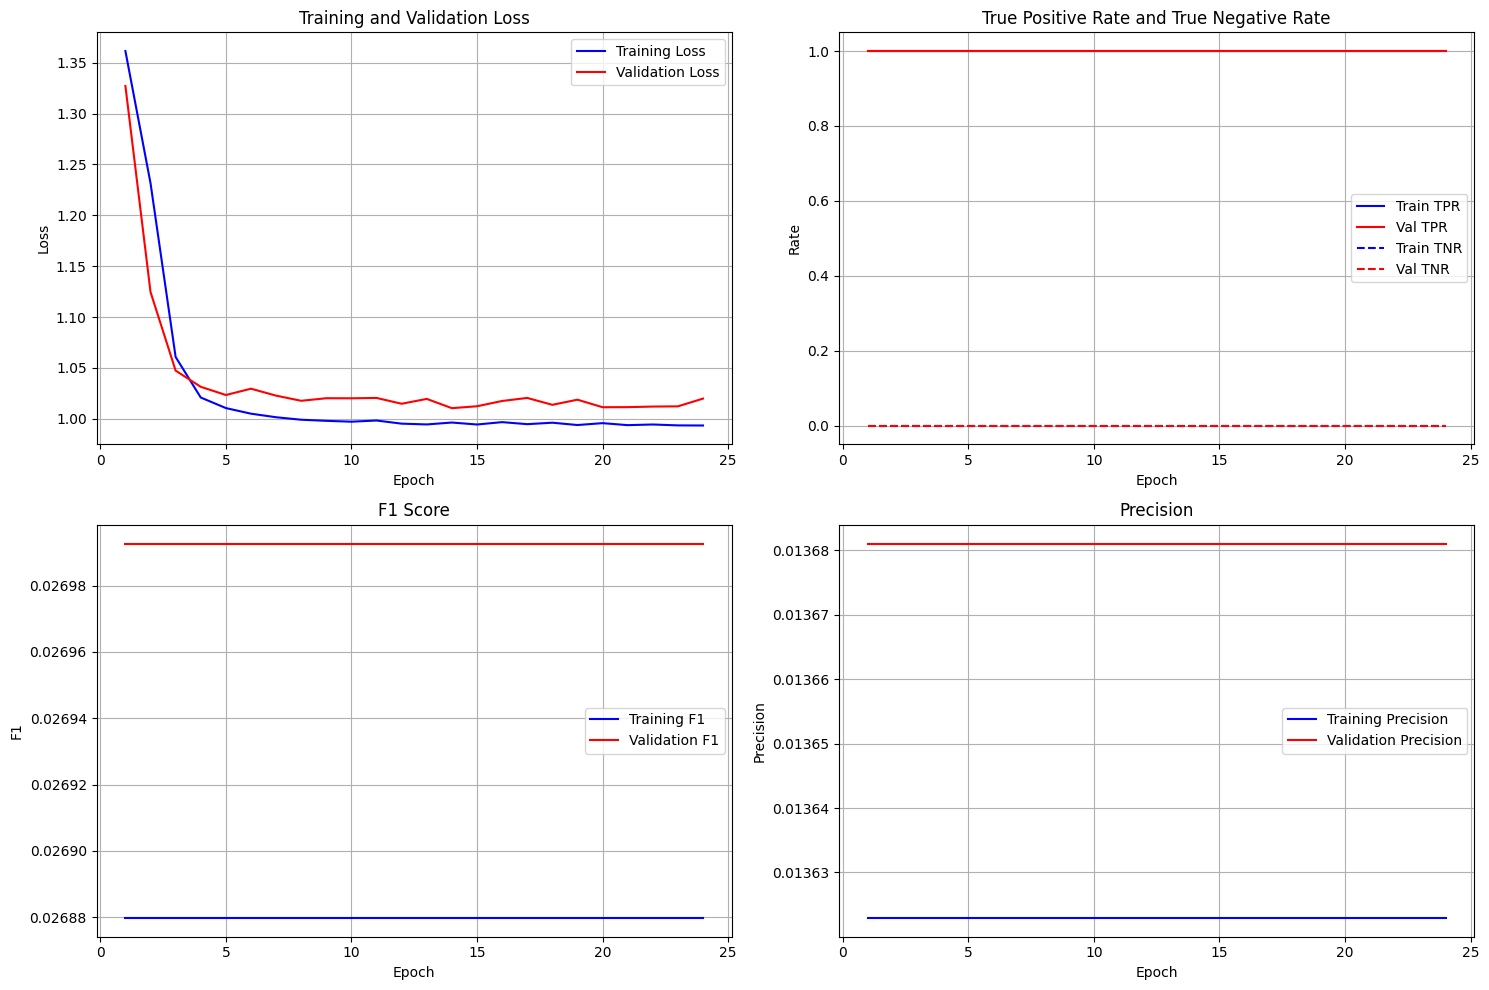

In [20]:
# Visualization functions
def plot_training_history(train_losses, val_losses, train_metrics, val_metrics):
    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot losses
    epochs = range(1, len(train_losses) + 1)
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot TPR/TNR
    train_tpr = [m['tpr'] for m in train_metrics]
    val_tpr = [m['tpr'] for m in val_metrics]
    train_tnr = [m['tnr'] for m in train_metrics]
    val_tnr = [m['tnr'] for m in val_metrics]
    
    ax2.plot(epochs, train_tpr, 'b-', label='Train TPR')
    ax2.plot(epochs, val_tpr, 'r-', label='Val TPR')
    ax2.plot(epochs, train_tnr, 'b--', label='Train TNR')
    ax2.plot(epochs, val_tnr, 'r--', label='Val TNR')
    ax2.set_title('True Positive Rate and True Negative Rate')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Rate')
    ax2.legend()
    ax2.grid(True)
    
    # Plot F1 scores
    train_f1 = [m['f1'] for m in train_metrics]
    val_f1 = [m['f1'] for m in val_metrics]
    
    ax3.plot(epochs, train_f1, 'b-', label='Training F1')
    ax3.plot(epochs, val_f1, 'r-', label='Validation F1')
    ax3.set_title('F1 Score')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('F1')
    ax3.legend()
    ax3.grid(True)
    
    # Plot precision
    train_prec = [m['precision'] for m in train_metrics]
    val_prec = [m['precision'] for m in val_metrics]
    
    ax4.plot(epochs, train_prec, 'b-', label='Training Precision')
    ax4.plot(epochs, val_prec, 'r-', label='Validation Precision')
    ax4.set_title('Precision')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Precision')
    ax4.legend()
    ax4.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(train_losses, val_losses, train_metrics, val_metrics)


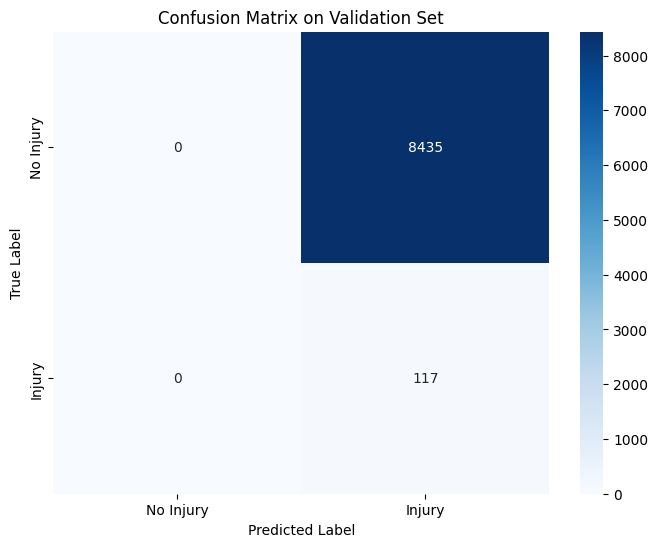

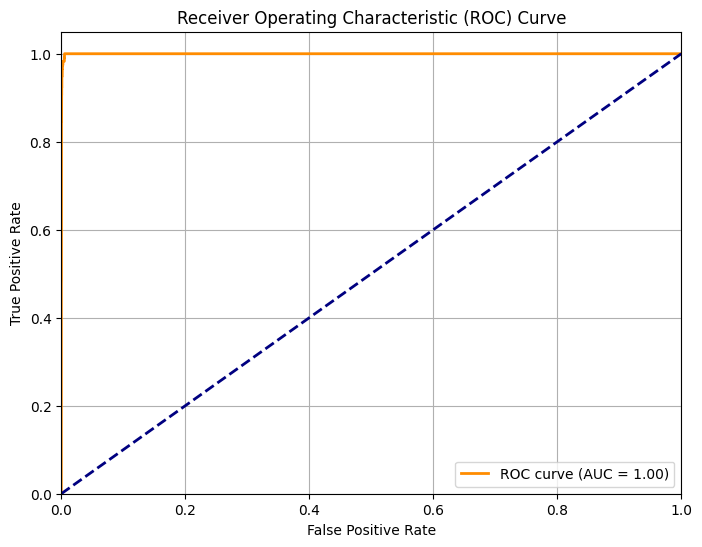

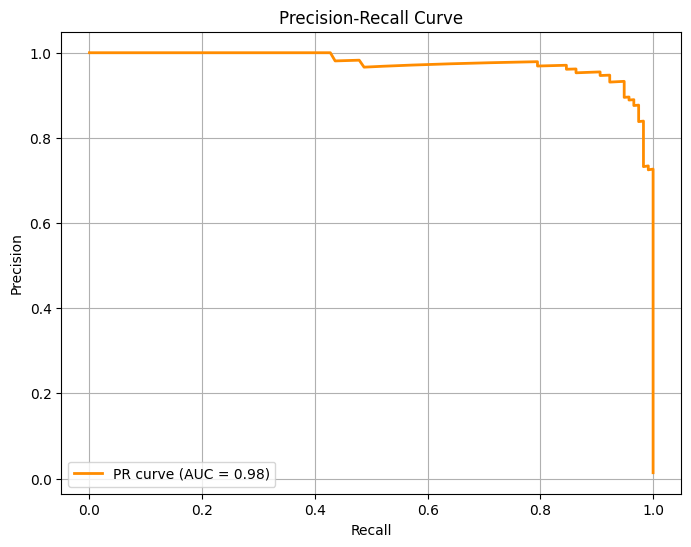


Final Validation Metrics:
Loss: 1.0104
True Positive Rate (TPR): 1.0000
True Negative Rate (TNR): 0.0000
Precision: 0.0137
F1 Score: 0.0270
ROC AUC: 0.9997
PR AUC: 0.9750


In [21]:
# Final evaluation on validation set
val_loss, val_pred, val_targets = evaluate(model, val_loader, criterion, device)
final_metrics = calculate_metrics(val_targets, val_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(final_metrics['confusion_matrix'], 
            annot=True, 
            fmt='d',
            cmap='Blues',
            xticklabels=['No Injury', 'Injury'],
            yticklabels=['No Injury', 'Injury'])
plt.title('Confusion Matrix on Validation Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate and plot ROC curve
fpr, tpr, _ = roc_curve(val_targets, val_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Calculate and plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(val_targets, val_pred)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

# Print final metrics
print("\nFinal Validation Metrics:")
print(f"Loss: {val_loss:.4f}")
print(f"True Positive Rate (TPR): {final_metrics['tpr']:.4f}")
print(f"True Negative Rate (TNR): {final_metrics['tnr']:.4f}")
print(f"Precision: {final_metrics['precision']:.4f}")
print(f"F1 Score: {final_metrics['f1']:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")


In [22]:
# Save model configuration and results
results = {
    'hyperparameters': {
        'sequence_length': SEQUENCE_LENGTH,
        'hidden_size': HIDDEN_SIZE,
        'num_layers': NUM_LAYERS,
        'dropout': DROPOUT,
        'learning_rate': LEARNING_RATE,
        'batch_size': BATCH_SIZE,
        'classification_threshold': CLASSIFICATION_THRESHOLD
    },
    'final_metrics': {
        'loss': val_loss,
        'tpr': final_metrics['tpr'],
        'tnr': final_metrics['tnr'],
        'precision': final_metrics['precision'],
        'f1': final_metrics['f1'],
        'roc_auc': roc_auc,
        'pr_auc': pr_auc
    },
    'feature_names': feature_names
}

import json
with open('gru_model_results.json', 'w') as f:
    json.dump(results, f, indent=4)

print("Model results saved to 'gru_model_results.json'")


Model results saved to 'gru_model_results.json'
